# Import Libraries/Packages & Datasets

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
proc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

## Set Working directory
## Load benign data, drop unwanted columns
 

In [73]:
fulldata = pd.read_csv('idsattacksprocessed\combined.csv')
fulldata['Label'].value_counts()

Label
DDOS attack-HOIC            683607
DDoS attacks-LOIC-HTTP      573061
DoS attacks-Hulk            455650
Benign                      361567
Bot                         280820
FTP-BruteForce              193331
SSH-Bruteforce              187469
Infilteration               152880
DoS attacks-SlowHTTPTest    139877
DoS attacks-GoldenEye        40668
DoS attacks-Slowloris        10468
DDOS attack-LOIC-UDP          1730
Brute Force -Web               600
Brute Force -XSS               219
SQL Injection                   86
Name: count, dtype: int64

In [74]:
train_datas = {}
test_datas = {}
train_datas_soft = {}
train_datas_soft_no_benign = {}
sel_labels = []
mixed_data = pd.DataFrame()
for i in fulldata['Label'].unique():
    if fulldata[fulldata['Label'] == i].shape[0] > 100000:
        print(i)
        sel_labels.append(i)
        train_datas[i] = fulldata[fulldata['Label'] == i][:100000]
        test_datas[i] = fulldata[fulldata['Label'] == i][100000:110000]
        mixed_data = pd.concat([mixed_data, fulldata[fulldata['Label'] == i][110000:120000]], axis=0)
        train_datas_soft_no_benign[i] = fulldata[fulldata['Label'] == i][:100000]
        if i != 'Benign':
            train_datas_soft[i] = pd.concat([fulldata[fulldata['Label'] == 'Benign'][50000:100000], fulldata[fulldata['Label'] == i][50000:100000]], axis=0)

Infilteration
Bot
DDoS attacks-LOIC-HTTP
SSH-Bruteforce
DoS attacks-SlowHTTPTest
Benign
DDOS attack-HOIC
DoS attacks-Hulk
FTP-BruteForce


In [75]:
for i in train_datas:
    print(train_datas[i])

       Unnamed: 0  Dst Port  Protocol  Timestamp  Flow Duration  Tot Fwd Pkts  \
0               0  0.006760  0.352941   0.274990       0.000002      0.009662   
1               1  0.006760  0.352941   0.275006       0.000002      0.009662   
2               2  0.006760  0.352941   0.275006       0.000005      0.009662   
3               3  0.006760  0.352941   0.275006       0.000006      0.009662   
4               4  0.006760  0.352941   0.275006       0.000007      0.009662   
...           ...       ...       ...        ...            ...           ...   
99995      105078  0.000809  1.000000   0.765017       0.000008      0.000000   
99996      105079  0.000809  1.000000   0.765017       0.000002      0.000000   
99997      105080  0.000809  1.000000   0.765017       0.000003      0.000000   
99998      105081  0.000809  1.000000   0.765017       0.000010      0.000000   
99999      105082  0.000809  1.000000   0.765017       0.000009      0.000000   

       Tot Bwd Pkts  TotLen

In [77]:
from sklearn.preprocessing import OneHotEncoder
labelencoder = OneHotEncoder()
labels = np.array(sel_labels).reshape(-1,1)
labelencoder.fit(labels)
encodedlabels = (labelencoder.transform(labels).todense()).tolist()
print(encodedlabels)
dikt = {}
for i in range(len(encodedlabels)):
    dikt[labels[i][0]] = encodedlabels[i]
dikt

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]]


{'Infilteration': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 'Bot': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDoS attacks-LOIC-HTTP': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'SSH-Bruteforce': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 'DoS attacks-SlowHTTPTest': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'Benign': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDOS attack-HOIC': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DoS attacks-Hulk': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'FTP-BruteForce': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]}

In [78]:
"""for i,row in soft_data.iterrows():
    soft_data.at[i,'Label'] = dikt[soft_data.at[i,'Label']]"""

"for i,row in soft_data.iterrows():\n    soft_data.at[i,'Label'] = dikt[soft_data.at[i,'Label']]"

In [79]:
del fulldata

In [80]:
mixed_data = mixed_data.sample(frac=1).reset_index(drop=True)
mixed_data_labels = list(mixed_data['Label'])
mixed_data.drop(['Label'], axis=1, inplace=True)
mixed_data = mixed_data.to_numpy()
for i in train_datas:
    train_datas[i].drop(['Label'], axis=1, inplace=True)
    test_datas[i].drop(['Label'], axis=1, inplace=True)
    train_datas[i] = train_datas[i].sample(frac=1).reset_index(drop=True)
    test_datas[i] = test_datas[i].sample(frac=1).reset_index(drop=True)
    train_datas[i] = train_datas[i].to_numpy()
    test_datas[i] = test_datas[i].to_numpy()

In [81]:
train_datas_soft_labels = {}
for i in train_datas_soft:
    train_datas_soft[i] = train_datas_soft[i].sample(frac=1).reset_index(drop=True)
    train_datas_soft_labels[i] = list(train_datas_soft[i]['Label'])
    train_datas_soft[i].drop(['Label'], axis=1, inplace=True)
    train_datas_soft[i] = train_datas_soft[i].to_numpy()

In [82]:
train_datas_soft_no_benign_labels = {}
for i in train_datas_soft_no_benign:
    train_datas_soft_no_benign[i] = train_datas_soft_no_benign[i].sample(frac=1).reset_index(drop=True)
    train_datas_soft_no_benign_labels[i] = list(train_datas_soft_no_benign[i]['Label'])
    train_datas_soft_no_benign[i].drop(['Label'], axis=1, inplace=True)
    train_datas_soft_no_benign[i] = train_datas_soft_no_benign[i].to_numpy()

In [83]:
train_datas_soft_labels_encoded = {}
for i in train_datas_soft_labels:
    train_datas_soft_labels_encoded[i] = []
    for j in train_datas_soft_labels[i]:
        train_datas_soft_labels_encoded[i].append(dikt[j])

In [84]:
train_datas_soft_no_benign_labels_encoded = {}
for i in train_datas_soft_no_benign_labels:
    train_datas_soft_no_benign_labels_encoded[i] = []
    for j in train_datas_soft_no_benign_labels[i]:
        train_datas_soft_no_benign_labels_encoded[i].append(dikt[j])

In [85]:
mixed_data_labels_encoded = []
for i in mixed_data_labels:
    mixed_data_labels_encoded.append(dikt[i])

In [86]:
#loading data into pytorch dataloader as train and test
devices = []
batch_size = 128
train_loader = {}
for i in train_datas:
  train_loader[i] = torch.utils.data.DataLoader(train_datas[i], batch_size = batch_size, shuffle=True)
  devices.append(i)

In [87]:
"""
train_soft_loader = {}
for i in train_datas_soft:
  train_soft_loader[i] = torch.utils.data.DataLoader(train_datas_soft[i], batch_size = batch_size)
"""

'\ntrain_soft_loader = {}\nfor i in train_datas_soft:\n  train_soft_loader[i] = torch.utils.data.DataLoader(train_datas_soft[i], batch_size = batch_size)\n'

In [88]:
"""
train_soft_no_benign_loader = {}
for i in train_datas_soft_no_benign:
  train_soft_no_benign_loader[i] = torch.utils.data.DataLoader(train_datas_soft_no_benign[i], batch_size = batch_size)
"""

'\ntrain_soft_no_benign_loader = {}\nfor i in train_datas_soft_no_benign:\n  train_soft_no_benign_loader[i] = torch.utils.data.DataLoader(train_datas_soft_no_benign[i], batch_size = batch_size)\n'

In [96]:
#initialising config variables
num_clients = len(train_loader)      # Number of clients
num_selected = len(train_loader)    # Typically, num_selected is around 30–40% of the num_clients.
#baseline_num = 1000  # choose some data from the train set to retrain the data from trained model
num_rounds = 2  #100      # Total number of communication rounds for the global model to train.
epochs = 5          # for train client model
#retrain_epochs = 3  # Total number of retraining rounds on the global server after receiving the model weights
                      # from all the clients that participated in the communication round.

## FedAvg / FedAvgM

In [97]:
# aggregates the model weights received from every client
# and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    #for model in client_models:
     #   model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()):
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    #for model in client_models:
     #   model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias



In [98]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
          output = client_model(data.float()) # tensor 115
          optimizer.zero_grad()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(proc), output)
          loss = nn.MSELoss(reduction='mean')(data.float().to(proc), output)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())

## Deep Auto-encoder Model

In [99]:
import torch.nn as nn

input_dim = train_loader['Benign'].dataset.shape[1]

class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        
        xavier_gain = nn.init.calculate_gain('tanh')
        
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 64)  
        self.fc3 = nn.Linear(64, 48)
        self.fc4 = nn.Linear(48, 32)
        self.fc5 = nn.Linear(32, 24)
        self.fc6 = nn.Linear(24, 16)
        self.fc7 = nn.Linear(16, 16)
        self.fc8 = nn.Linear(16, 24)
        self.fc9 = nn.Linear(24, 32)
        self.fc10 = nn.Linear(32, 48)
        self.fc11 = nn.Linear(48, 64)
        self.fc12 = nn.Linear(64, input_dim)
        self.fc13 = nn.Linear(input_dim, input_dim)
       
        self.activation = nn.Tanh()
        
        nn.init.xavier_uniform_(self.fc1.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc2.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc3.weight, gain=xavier_gain) 
        nn.init.xavier_uniform_(self.fc4.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc5.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc6.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc7.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc8.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc9.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc10.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc11.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc12.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc13.weight, gain=xavier_gain)
        
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        x = self.fc8(x) 
        x = self.activation(x)
        x = self.fc9(x)
        x = self.activation(x)
        x = self.fc10(x) 
        x = self.activation(x)
        x = self.fc11(x)
        x = self.activation(x)
        x = self.fc12(x)
        x = self.activation(x)
        x = self.fc13(x)
        return x

## Initialisation

In [100]:
global_model = AEModel(input_dim).to(proc)
client_models = {}
for i in devices:
    client_models[i] = AEModel(input_dim).to(proc)
opt = {}
for i in devices:
    opt[i] = optim.Adam(client_models[i].parameters(), lr=0.001)

In [101]:
"""# Initializing models and optimizer

global_model = AEModel(input_dim).to(proc)
client_models = [AEModel(input_dim).to(proc) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())

# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}
#opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]
# lr_list = [0.012, 0.012, 0.012, 0.00005]
# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]
opt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]"""

"# Initializing models and optimizer\n\nglobal_model = AEModel(input_dim).to(proc)\nclient_models = [AEModel(input_dim).to(proc) for _ in range(num_selected)] # part or all clients\n# print(client_models)\nfor model in client_models:\n    model.load_state_dict(global_model.state_dict())\n\n# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}\n#opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]\n# lr_list = [0.012, 0.012, 0.012, 0.00005]\n# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]\n# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]\nopt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]"

# Training Federated Model

In [102]:
# Train Client Model and Global Model
start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    #client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    #client_idx = list(range(num_clients))
    #print('client_idx: ', client_idx)
    #client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] # Need to fix this. It is part of server aggregation.
    # client_lens = [len(train_lotrain_loaderader[idx]) for idx in client_idx ]
    #print(client_lens)


    #### client update ####
    loss = 0
    for i in devices:
        # print(i)
        #client_syn(client_models[i], global_model)
        # print(train_loader[devices[client_idx[i]]])
        l = client_update(client_models[i], opt[i], train_loader[i], epochs)
        print('client: ', i, 'loss: ', l)
        loss += l

    #### retraining on the global server ####
    #loss_retrain = 0
    #for i in tqdm(range(num_selected)):
    #    loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    #train_loss_global.append(loss_retrain/num_selected)

    """attackclients = []
    for i in devices:
        if i != 'Benign':
            attackclients.append(client_models[i])"""
    
    ### aggregate models ###
    #server_aggregate(global_model, attackclients, client_lens)      # FedAvg
    #server_aggregate_M(global_model, attackclients, client_lens)    # FedAvgM

time_required = time.time() - start_time
print('/nTIME: {}mins'.format(time_required/60))


round:  1
client:  Infilteration loss:  53184029.27877238
client:  Bot loss:  49715617.72378517
client:  DDoS attacks-LOIC-HTTP loss:  48798245.12531969
client:  SSH-Bruteforce loss:  47987630.97186701
client:  DoS attacks-SlowHTTPTest loss:  47938675.58567775
client:  Benign loss:  51564709.58567775
client:  DDOS attack-HOIC loss:  48757369.50383632
client:  DoS attacks-Hulk loss:  50481427.44757033
client:  FTP-BruteForce loss:  47942682.86956522

round:  2
client:  Infilteration loss:  52769898.87468031
client:  Bot loss:  49303557.47314578
client:  DDoS attacks-LOIC-HTTP loss:  48425015.22762148
client:  SSH-Bruteforce loss:  47593858.803069055
client:  DoS attacks-SlowHTTPTest loss:  47544983.10997442
client:  Benign loss:  51186661.81585678
client:  DDOS attack-HOIC loss:  48365758.189258315
client:  DoS attacks-Hulk loss:  50076014.94629156
client:  FTP-BruteForce loss:  47556167.437340155
/nTIME: 5.469231955210367mins


In [23]:
# save model
torch.save(global_model,'modelsprocessed/globalattackmodel.pt')

In [103]:
for i in devices:
  torch.save(client_models[i],'modelsprocessed/clients/' + i + '.pt')

### Client Test

In [104]:
client_models = {}
for device in devices:
  client_models[device] = torch.load('modelsprocessed/clients/' + device + '.pt')

In [105]:
def quan_thresh(model, dataloader, quantile=0.9):
  model.eval()
  se = []
  
  for batch in dataloader:
    
    for data in batch:
      error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2) # len(error) = 66
      se.append(sum(error))
    # Calculate threshold as quantile of errors 
    #thresh = np.quantile(se, quantile, axis=0) #before it was thresh = np.quantile(mse, quantile)
    #errs.append(thresh)
  #thresh = np.quantile(mse, quantile)
  return np.mean(se) + np.std(se), np.quantile(se, quantile), se #before it was np.mean(errs)
  #return thresh

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
           TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
           FP += 1
        if y_actual[i] == y_pred[i] == 0:
           TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

In [106]:
thresholds = {}
quans = {}
errors = {}
for device in devices:
    model = client_models[device]
    dataloader = train_loader[device]
    thresholds[device], quans[device], errors[device] = quan_thresh(model, dataloader)
    #thresholds[devices[i]] = quan_recon(model, dataloader)
print(thresholds)

{'Infilteration': 6900501532.9079895, 'Bot': 6442244944.985835, 'DDoS attacks-LOIC-HTTP': 6337215922.205471, 'SSH-Bruteforce': 6234863298.440814, 'DoS attacks-SlowHTTPTest': 6228985503.304058, 'Benign': 6702655952.397251, 'DDOS attack-HOIC': 6344134380.492754, 'DoS attacks-Hulk': 6513657054.031355, 'FTP-BruteForce': 6229382133.97394}


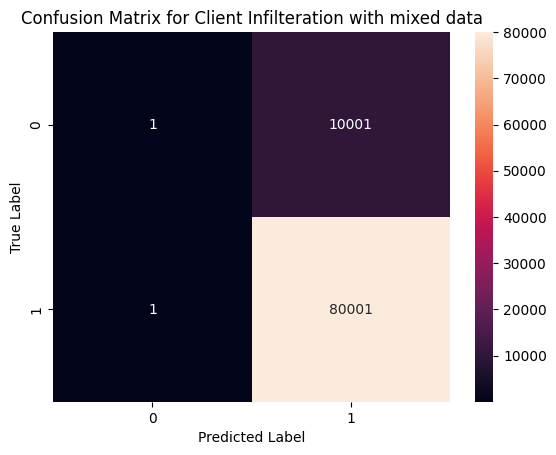

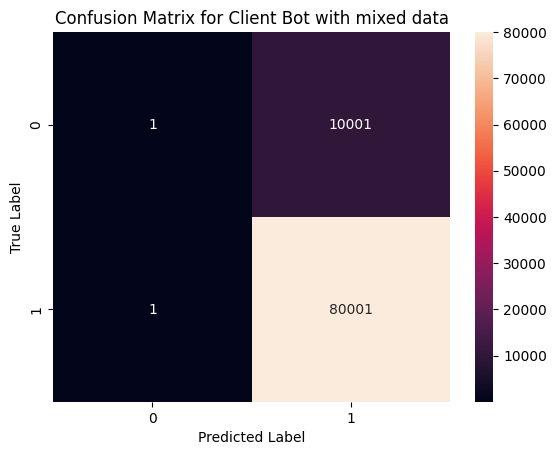

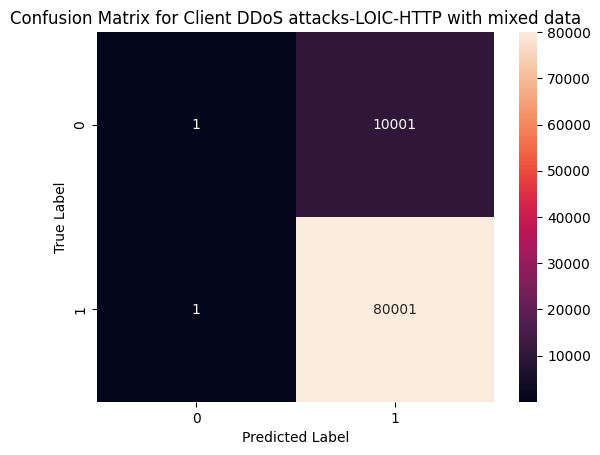

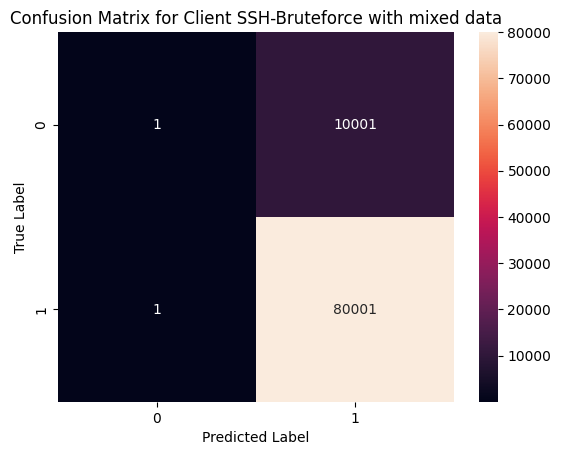

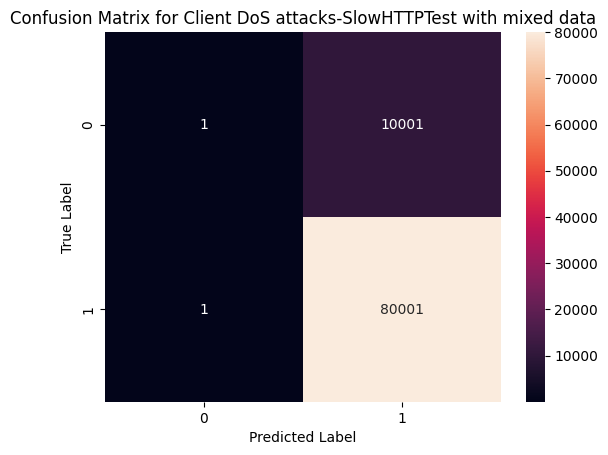

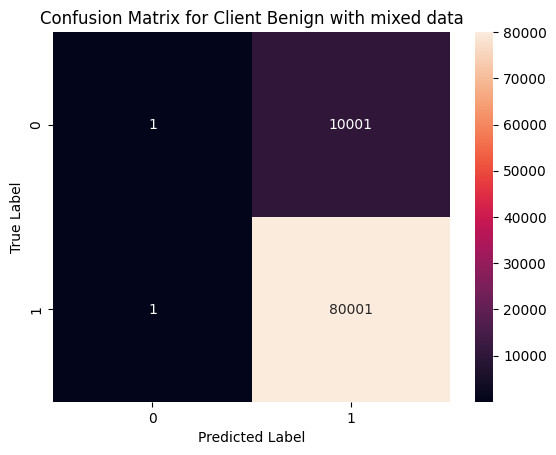

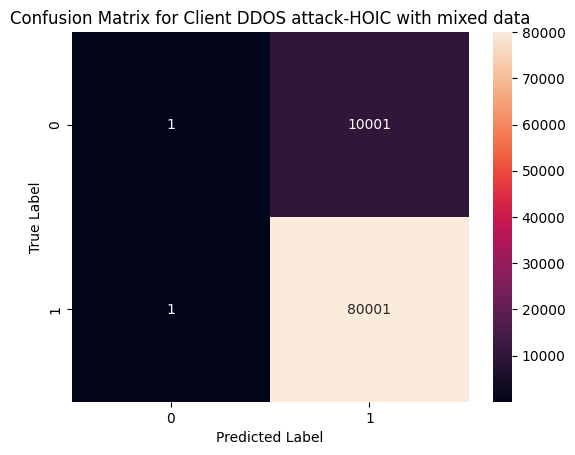

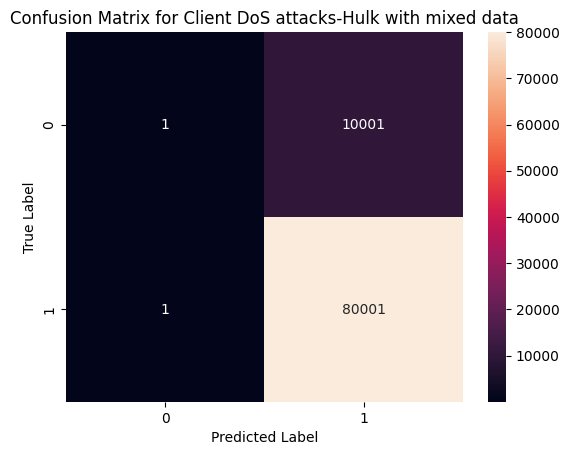

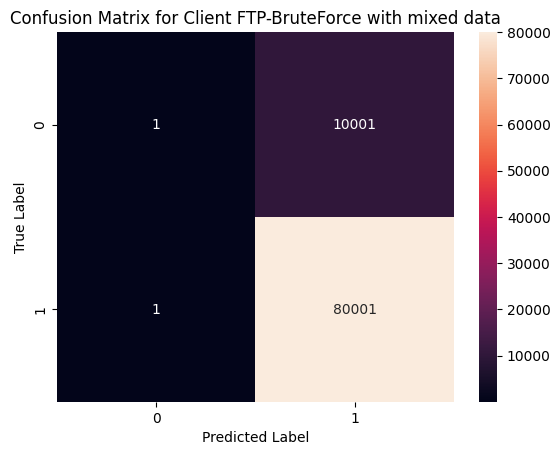

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata, pearsonr
from sklearn.metrics import mutual_info_score
selectedattackbenmix_stats = []
res=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
#  if device == 'Infilteration.csv':
  model = client_models[device]
  model.eval()
  labels = mixed_data_labels
  threshold = thresholds[device]
  temp=[]
  y_true = []
  y_pred = []
  ind = 0
  for data in mixed_data:
      data = torch.Tensor(data)
      error = np.sum(np.power(data.detach().numpy() - model(data).detach().numpy(), 2))
      temp.append(error)
      if device == labels[ind]:
          y_true.append(1)
          y_pred.append(1 if error < threshold else 0)
      else:
          y_true.append(0)
          y_pred.append(0 if error >= threshold else 1)
      #cf.append([coeff, p, device[:-4] == labels[ind]])
      ind += 1
  res.append([device,min(temp),max(temp)])
  TP, FP, TN, FN = perf_measure(y_true, y_pred)
  TP += 1
  FN += 1
  TN += 1
  FP += 1
  conf_matrix = [[TP, FN], [FP, TN]]
  plt.figure() 
  sns.heatmap(conf_matrix, annot=True, fmt="d")
  plt.title("Confusion Matrix for Client " + str(device) +" with mixed data")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

  acc = (TP+TN) / (TP+TN+FP+FN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1score = 2 * ((precision * recall) / (precision + recall))

  TPR = round((TP / (TP+FN)), 6)
  # print('TPR is: {}%'.format(TPR))

  FPR = round((FP / (FP + TN)), 6)
  # print('TPR is: {}%'.format(FPR))

  selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with mixed data"),acc*100,precision,recall,F1score*100,TPR,FPR])

  #   [['TP', 'FN']
  #   ['FP', 'TN']]

In [108]:
for i in selectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Client Infilteration with mixed data
Accuracy: 88.88716057064131
Precision: 0.5
Recall: 9.998000399920016e-05
F1 score : 0.01999200319872051
TPR : 0.0001
FPR : 1.2e-05
Title: Stats for Client Bot with mixed data
Accuracy: 88.88716057064131
Precision: 0.5
Recall: 9.998000399920016e-05
F1 score : 0.01999200319872051
TPR : 0.0001
FPR : 1.2e-05
Title: Stats for Client DDoS attacks-LOIC-HTTP with mixed data
Accuracy: 88.88716057064131
Precision: 0.5
Recall: 9.998000399920016e-05
F1 score : 0.01999200319872051
TPR : 0.0001
FPR : 1.2e-05
Title: Stats for Client SSH-Bruteforce with mixed data
Accuracy: 88.88716057064131
Precision: 0.5
Recall: 9.998000399920016e-05
F1 score : 0.01999200319872051
TPR : 0.0001
FPR : 1.2e-05
Title: Stats for Client DoS attacks-SlowHTTPTest with mixed data
Accuracy: 88.88716057064131
Precision: 0.5
Recall: 9.998000399920016e-05
F1 score : 0.01999200319872051
TPR : 0.0001
FPR : 1.2e-05
Title: Stats for Client Benign with mixed data
Accuracy: 88.8871

## Global model creation

In [ ]:
client_models = {}
for device in devices:
  client_models[device] = torch.load('modelsprocessed/clients/' + device + '.pt')

In [ ]:
def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        out = x
        x = self.fc8(x) 
        x = self.activation(x)
        x = self.fc9(x)
        x = self.activation(x)
        x = self.fc10(x) 
        x = self.activation(x)
        x = self.fc11(x)
        x = self.activation(x)
        x = self.fc12(x)
        x = self.activation(x)
        x = self.fc13(x)
        return out

In [25]:
client_models.pop('Benign')

AEModel(
  (fc1): Linear(in_features=69, out_features=69, bias=True)
  (fc2): Linear(in_features=69, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=48, bias=True)
  (fc4): Linear(in_features=48, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=24, bias=True)
  (fc6): Linear(in_features=24, out_features=16, bias=True)
  (fc7): Linear(in_features=16, out_features=16, bias=True)
  (fc8): Linear(in_features=16, out_features=24, bias=True)
  (fc9): Linear(in_features=24, out_features=32, bias=True)
  (fc10): Linear(in_features=32, out_features=48, bias=True)
  (fc11): Linear(in_features=48, out_features=64, bias=True)
  (fc12): Linear(in_features=64, out_features=69, bias=True)
  (fc13): Linear(in_features=69, out_features=69, bias=True)
  (activation): Tanh()
)

In [26]:
#noise
compressed_outs = {}
compressed_outs_test = {}

for i in client_models:
    model = client_models[i]
    model.__class__.forward = forward
    model.eval()
    dataloader = train_loader[i]
    outs = []
    ind = 0
    flag = False
    for batch in dataloader:
        for data in batch:
            layer_output = model(data.float())
            outs.append(layer_output)
            ind += 1
            if ind == 10000:
                compressed_outs[i] = outs
                outs = []
            elif ind == 20000:
                compressed_outs_test[i] = outs
                flag = True
                break
        if flag:
            break

In [27]:
loader = train_loader['Benign']
for i in client_models:
    model = client_models[i]
    model.eval()
    outs = []
    ind = 0
    flag = False
    for batch in dataloader:
        for data in batch:
            layer_output = model(data.float())
            outs.append(layer_output)
            ind += 1
            if ind == 1000:
                for j in range(len(outs)):
                            compressed_outs.setdefault('not', []).append(outs[j])
                outs = []
            elif ind == 2000:
                for k in range(len(outs)):
                            compressed_outs_test.setdefault('not', []).append(outs[k])
                flag = True
                break
        if flag:
            break

In [28]:
for i in compressed_outs_test.keys():
    print(i,': ',len(compressed_outs_test[i]))

Bot :  10000
DDOS attack-HOIC :  10000
DDoS attacks-LOIC-HTTP :  10000
DoS attacks-Hulk :  10000
DoS attacks-SlowHTTPTest :  10000
FTP-BruteForce :  10000
Infilteration :  10000
SSH-Bruteforce :  10000
not :  8000


In [29]:
for i in compressed_outs.keys():
    print(i,': ',len(compressed_outs[i]))


Bot :  10000
DDOS attack-HOIC :  10000
DDoS attacks-LOIC-HTTP :  10000
DoS attacks-Hulk :  10000
DoS attacks-SlowHTTPTest :  10000
FTP-BruteForce :  10000
Infilteration :  10000
SSH-Bruteforce :  10000
not :  8000


In [31]:
sel_labels.remove('Benign')
sel_labels.append('not')

In [50]:
sel_labels

['Bot',
 'DDOS attack-HOIC',
 'DDoS attacks-LOIC-HTTP',
 'DoS attacks-Hulk',
 'DoS attacks-SlowHTTPTest',
 'FTP-BruteForce',
 'Infilteration',
 'SSH-Bruteforce',
 'not']

In [51]:
from sklearn.preprocessing import OneHotEncoder
labelencoder = OneHotEncoder()
labels = np.array(sel_labels).reshape(-1,1)
labelencoder.fit(labels)
encodedlabels = (labelencoder.transform(labels).todense()).tolist()
dikt = {}
for i in range(len(encodedlabels)):
    dikt[labels[i][0]] = encodedlabels[i]
dikt

{'Bot': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDOS attack-HOIC': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDoS attacks-LOIC-HTTP': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DoS attacks-Hulk': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DoS attacks-SlowHTTPTest': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'FTP-BruteForce': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'Infilteration': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 'SSH-Bruteforce': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 'not': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]}

c:\Users\amenu4aie20110\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


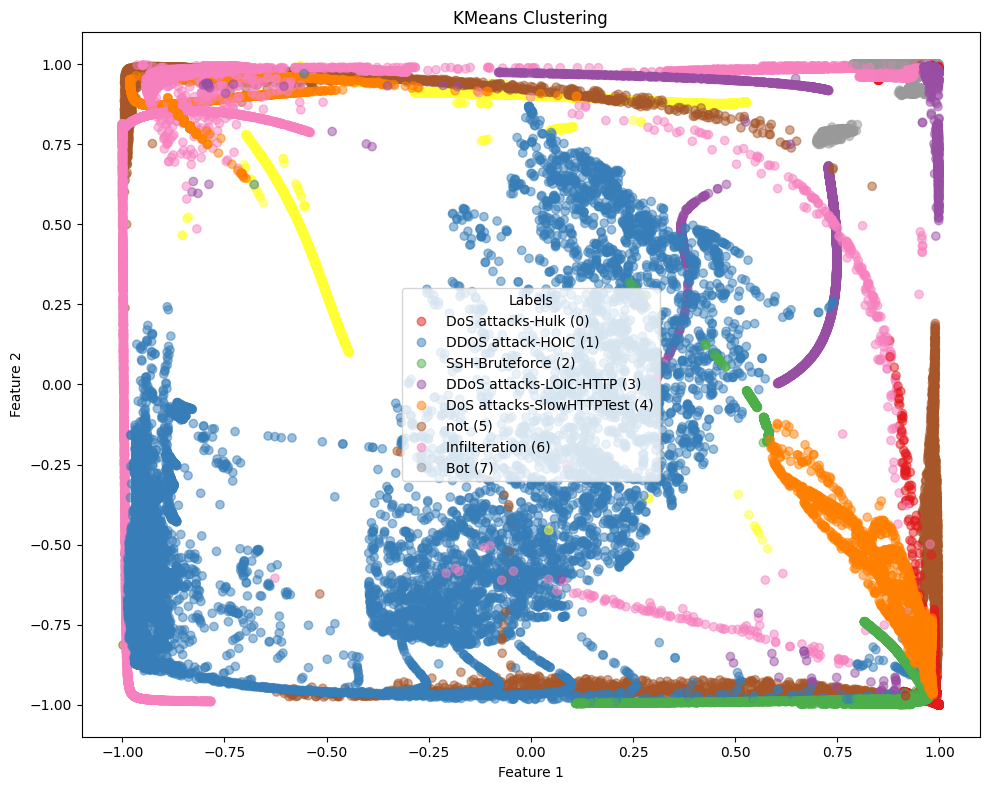

In [34]:
import numpy as np
from sklearn.cluster import KMeans  # Change here
import matplotlib.pyplot as plt

# Extract data from the dictionary
data = []
labels = []

for label, tensors in compressed_outs.items():
    for tensor in tensors:
        data.append(tensor.detach().numpy())
        labels.append(label)

data = np.array(data)

# Apply KMeans clustering  # Change here
kmeans = KMeans(n_clusters=16, random_state=42)  # You may need to adjust the number of clusters
cluster_labels = kmeans.fit_predict(data)

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 8))

# Visualize the clusters with different colors for each label
scatter = ax.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='Set1', alpha=0.5)

# Add legend with label names only if there are valid elements
if scatter.legend_elements()[0] is not None and len(scatter.legend_elements()[0]) > 0:
    unique_labels = list(set(labels))
    legend_labels = [f'{label} ({i})' for i, label in enumerate(unique_labels)]
    ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Labels')

ax.set_title('KMeans Clustering')  # Change here
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

plt.tight_layout()  # Adjust layout

plt.show()

In [52]:
proc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = compressed_outs['Bot'][0].shape[0]
classify = len(compressed_outs.keys())

class GlobalModel(nn.Module):
    def __init__(self, input_dim):
        super(GlobalModel, self).__init__()
        
        xavier_gain = nn.init.calculate_gain('tanh')
        
        self.fc1 = nn.Linear(input_dim, 24)
        self.fc2 = nn.Linear(24, 32)
        self.fc3 = nn.Linear(32, 48)
        self.fc4 = nn.Linear(48, 69)
        self.fc5 = nn.Linear(69, 32)
        self.fc6 = nn.Linear(32, 18)
        self.fc7 = nn.Linear(18, classify)
       
        self.activation = nn.Tanh()
        nn.init.xavier_uniform_(self.fc1.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc2.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc3.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc4.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc5.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc6.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc7.weight, gain=xavier_gain)

        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x)
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        return x

global_model = GlobalModel(input_dim).to(proc)
opt= torch.optim.Adam(global_model.parameters(), lr = 0.012, weight_decay=1e-05)

In [53]:
def global_update(global_model, optimizer, train_data, target_labels, epoch):
    for e in range(epoch):
        running_loss = 0.0
        prev = 0
        ind = 128
        for data in train_data:
          global_model.train()
          output = global_model(data.float()) # tensor 115
          optimizer.zero_grad()
          global_model.eval()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(proc), output)
          target_label = torch.Tensor(target_labels[prev:ind])
          loss = nn.CrossEntropyLoss()(output, target_label)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
          prev = ind
          ind += 128
          if ind > len(target_labels):
            ind = len(target_labels)
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss

In [54]:
epochs = 100
batch_size = 128

In [55]:
import random

detached_tensors = []
detached_labels = []

# Iterate through the tensors and detach them
for key, tensor_list in compressed_outs.items():
    for tensor in tensor_list:
        detached_labels.append(dikt[key])
        dt = tensor.detach().numpy()  # Detach from computation graph and convert to NumPy array if needed
        detached_tensors.append(dt)

idxs = list(range(len(detached_tensors)))
# Shuffle the indices
idxs = shuffle(idxs)

# Use the indices to shuffle the tensors and labels
shuffled_tensors = [detached_tensors[i] for i in idxs] 
shuffled_labels = [detached_labels[i] for i in idxs]

shuffled_data_loader = DataLoader(shuffled_tensors, batch_size=batch_size)

In [56]:
loss = global_update(global_model, opt, shuffled_data_loader, shuffled_labels, epochs)
print(loss)

0.1003988708077042


In [57]:
torch.save(global_model, 'models16/globalattackmodel.pt')

In [58]:
global_model = torch.load('models16/globalattackmodel.pt')

In [59]:
detached_tensors_test = []
detached_labels_test= []

# Iterate through the tensors and detach them
for key, tensor_list in compressed_outs_test.items():
    for tensor in tensor_list:
        detached_labels_test.append(dikt[key])
        dt = tensor.detach().numpy()  # Detach from computation graph and convert to NumPy array if needed
        detached_tensors_test.append(dt)

In [60]:
labels = []
for i in detached_labels_test:
    labels.append(i.index(1))
print(len(labels))

88000


<Axes: >

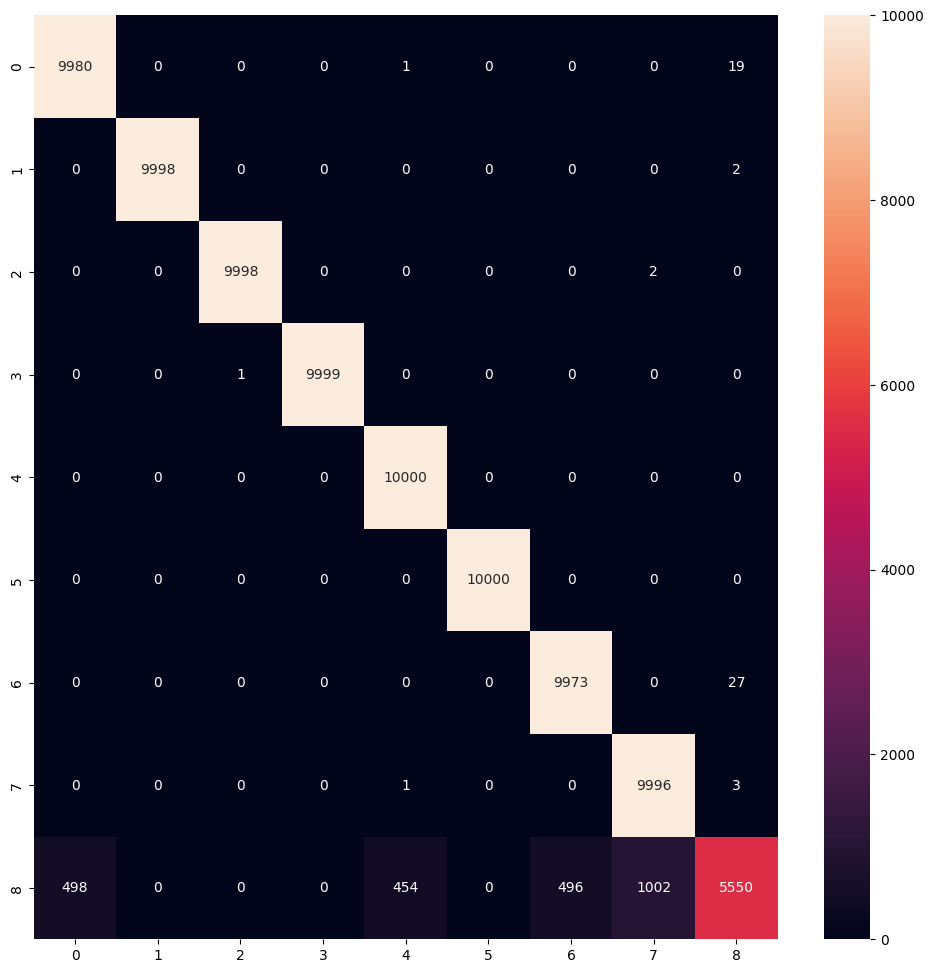

In [61]:
from sklearn.metrics import confusion_matrix
model = global_model
model.eval()
temp_test = []
temp = []
for data in detached_tensors_test:
    data = torch.Tensor(data).reshape(1,-1)
    pred = nn.Softmax(dim=1)(model(data).float())
    temp.append(pred)
    pred = pred.argmax(dim=1)
    temp_test.append(pred)
cm = confusion_matrix(labels, temp_test)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g')

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have the confusion matrix stored in the variable 'cm'
# Calculate accuracy
accuracy = accuracy_score(labels, temp_test)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(labels, temp_test, average='weighted')
recall = recall_score(labels, temp_test, average='weighted')
f1 = f1_score(labels, temp_test, average='weighted')

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for each class
TPR = []
FPR = []
for i in range(cm.shape[0]):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FN - FP
    TPR.append(TP / (TP + FN))
    FPR.append(FP / (FP + TN))

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TPR:", TPR)
print("FPR:", FPR)

Accuracy: 0.9715227272727273
Precision: 0.9730483407153999
Recall: 0.9715227272727273
F1 Score: 0.9694835374433393
TPR: [0.998, 0.9998, 0.9998, 0.9999, 1.0, 1.0, 0.9973, 0.9996, 0.69375]
FPR: [0.006384615384615384, 0.0, 1.282051282051282e-05, 0.0, 0.005846153846153846, 0.0, 0.006358974358974359, 0.012871794871794871, 0.0006375]


In [63]:
dikt

{'Bot': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDOS attack-HOIC': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDoS attacks-LOIC-HTTP': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DoS attacks-Hulk': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DoS attacks-SlowHTTPTest': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'FTP-BruteForce': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'Infilteration': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 'SSH-Bruteforce': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 'not': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]}

In [64]:
compressed_mixed = {}
for data in mixed_data:
    for i in client_models:
        model = client_models[i]
        model.eval()
        layer_output = model(torch.Tensor(data))
        try:
            compressed_mixed[i].append(layer_output)
        except:
            compressed_mixed[i] = [layer_output]

In [65]:
mixed_data_labels

['DoS attacks-SlowHTTPTest',
 'FTP-BruteForce',
 'Benign',
 'SSH-Bruteforce',
 'FTP-BruteForce',
 'Bot',
 'SSH-Bruteforce',
 'FTP-BruteForce',
 'Benign',
 'DoS attacks-Hulk',
 'FTP-BruteForce',
 'DDoS attacks-LOIC-HTTP',
 'DoS attacks-Hulk',
 'Benign',
 'DDoS attacks-LOIC-HTTP',
 'DoS attacks-Hulk',
 'DDoS attacks-LOIC-HTTP',
 'SSH-Bruteforce',
 'DoS attacks-SlowHTTPTest',
 'SSH-Bruteforce',
 'Infilteration',
 'Benign',
 'DoS attacks-SlowHTTPTest',
 'DDoS attacks-LOIC-HTTP',
 'DoS attacks-SlowHTTPTest',
 'Benign',
 'Benign',
 'Infilteration',
 'Bot',
 'DDoS attacks-LOIC-HTTP',
 'Infilteration',
 'Infilteration',
 'Benign',
 'Bot',
 'DoS attacks-SlowHTTPTest',
 'DoS attacks-SlowHTTPTest',
 'Infilteration',
 'DDOS attack-HOIC',
 'Benign',
 'Infilteration',
 'Benign',
 'DoS attacks-Hulk',
 'DDoS attacks-LOIC-HTTP',
 'DDoS attacks-LOIC-HTTP',
 'DDoS attacks-LOIC-HTTP',
 'Infilteration',
 'DoS attacks-SlowHTTPTest',
 'Benign',
 'Benign',
 'DDOS attack-HOIC',
 'Benign',
 'DoS attacks-SlowHTT

In [66]:
len(mixed_data_labels_encoded)

90000

In [67]:
len(compressed_mixed)

8

In [68]:
compressed_mixed.keys()

dict_keys(['Bot', 'DDOS attack-HOIC', 'DDoS attacks-LOIC-HTTP', 'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest', 'FTP-BruteForce', 'Infilteration', 'SSH-Bruteforce'])

In [69]:
len(compressed_mixed['Bot'])

90000

In [70]:
global_model.eval()
preds = {}
for i in range(len(compressed_mixed['Bot'])):
    client_preds = []
    for key in compressed_mixed:
            data = compressed_mixed[key][i]
            data = torch.Tensor(data).reshape(1,-1)
            pred = nn.Softmax(dim=1)(global_model(data).float())
            #client_preds.append(pred)
            client_preds.append(int(pred.argmax(dim=1)))
    preds[i] = client_preds

In [71]:
len(preds)

90000

In [72]:
labdikts = {}
for i in range(len(preds)):
    label = mixed_data_labels_encoded[i].index(1)
    try:
        labdikts[label].append(preds[i])
    except:
        labdikts[label] = [preds[i]]

In [73]:
from collections import Counter
c = Counter([8, 8, 2, 8, 4, 1, 6, 0])
for i in c:
    print(i, c[i])

8 3
2 1
4 1
1 1
6 1
0 1


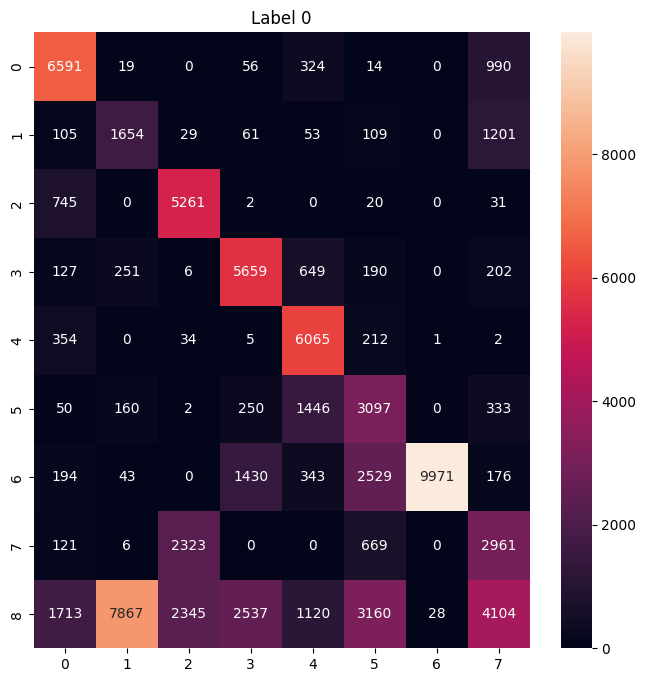

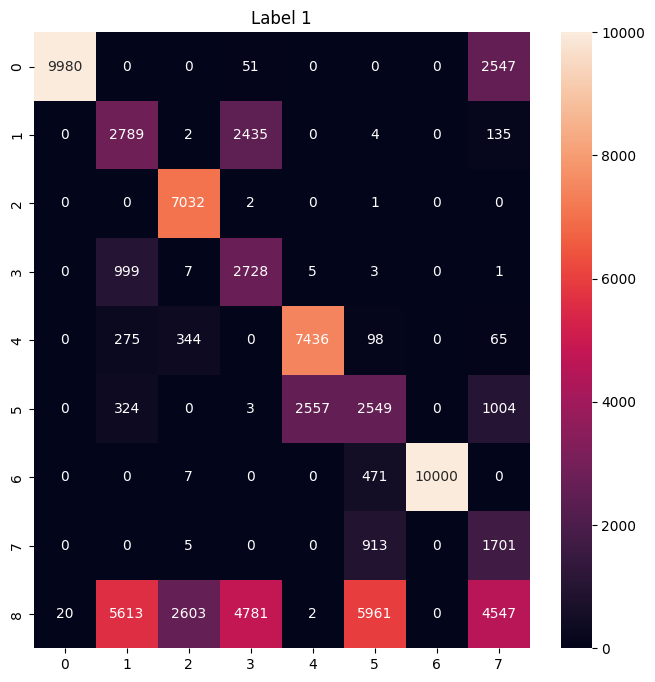

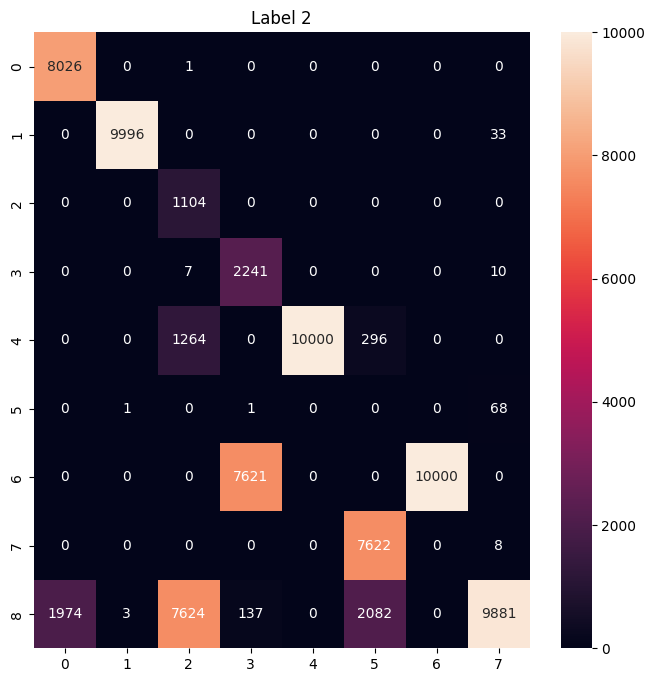

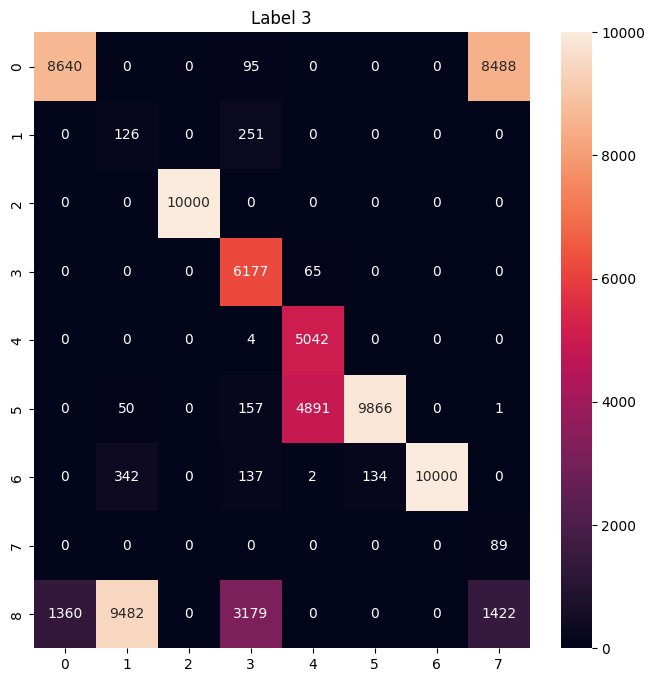

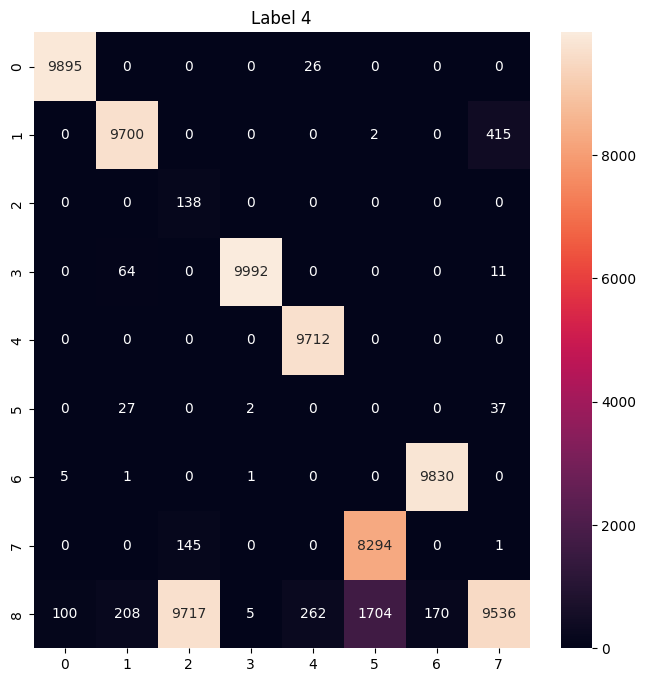

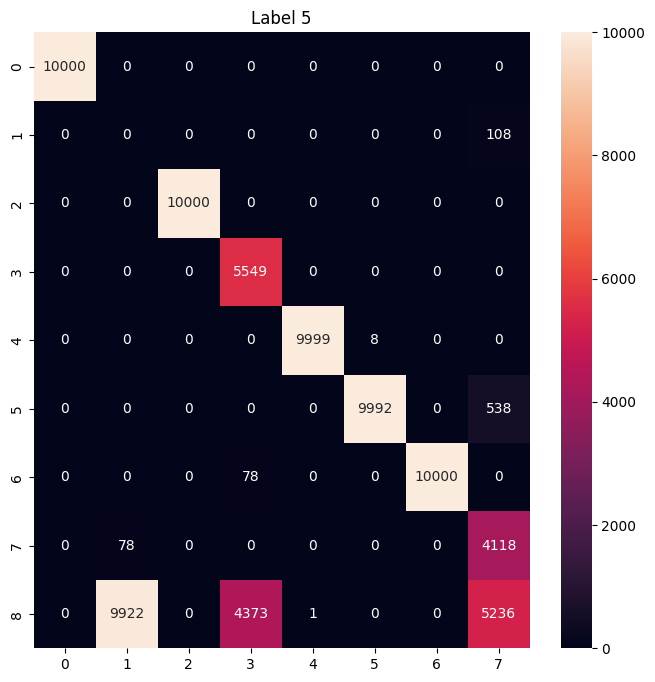

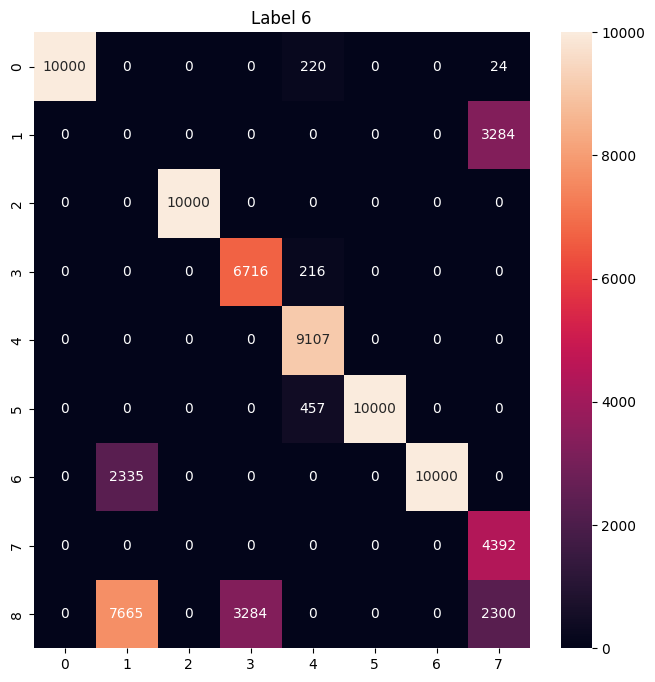

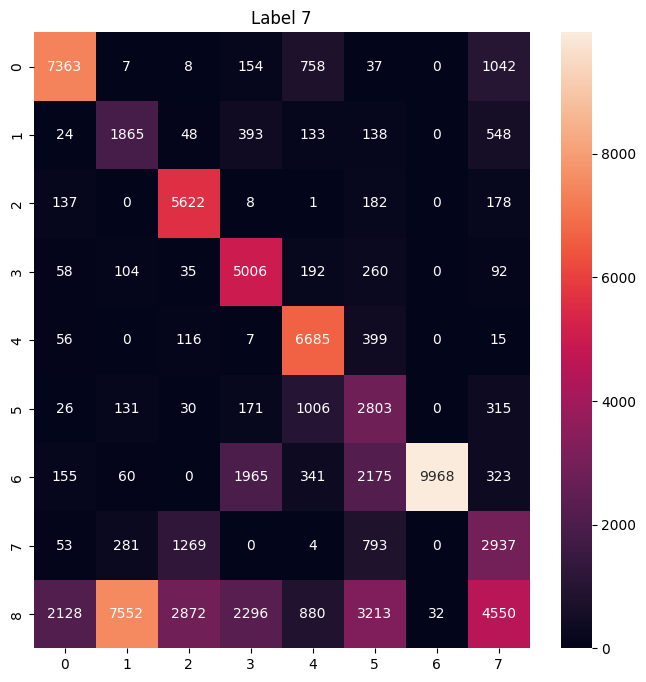

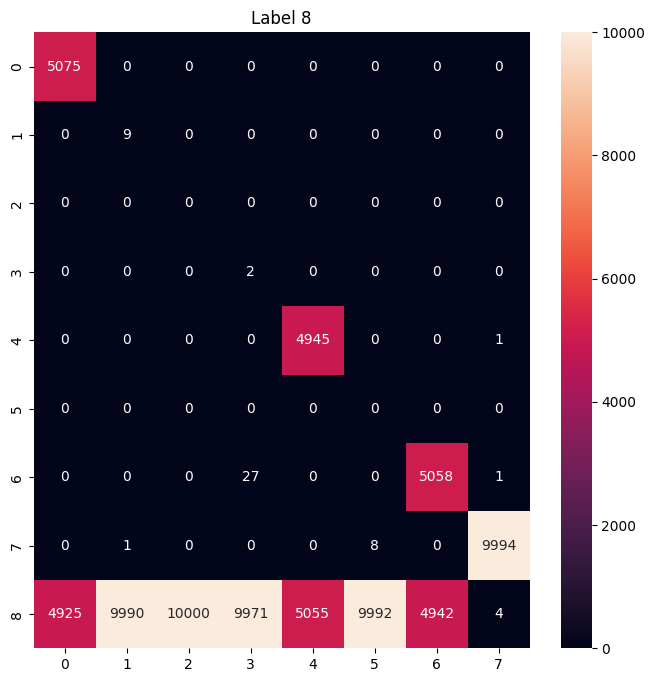

In [74]:
from collections import Counter
for i in range(9):
    arr = np.array(labdikts[i])
    mat = np.zeros((9, 8))
    for j in range(arr.shape[1]):
        c = Counter(arr[:, j])
        for k in c:
            mat[k, j] = c[k]
    plt.figure(figsize=(8, 8))
    plt.title("Label " + str(i))
    plt.ylabel("Predicted")
    plt.xlabel("Clients")
    sns.heatmap(mat, annot=True, fmt='g')     
    plt.show()

In [82]:
for i in range(len(preds)):
    print(preds[i], mixed_data_labels_encoded[i].index(1))

[0, 8, 2, 3, 4, 5, 6, 8] 5
[8, 8, 2, 3, 4, 5, 8, 3] 6
[0, 8, 2, 3, 5, 3, 6, 0] 0
[8, 8, 8, 8, 8, 8, 8, 8] 8
[0, 8, 2, 3, 5, 5, 6, 8] 6
[0, 8, 2, 8, 4, 3, 6, 8] 1
[8, 8, 8, 8, 8, 8, 8, 8] 8
[0, 8, 2, 3, 4, 5, 6, 8] 6
[3, 8, 2, 3, 3, 3, 6, 0] 0
[0, 1, 8, 3, 8, 8, 6, 8] 4
[0, 8, 2, 3, 4, 5, 6, 8] 6
[0, 8, 2, 8, 5, 5, 6, 0] 3
[0, 1, 8, 3, 8, 8, 6, 8] 4
[8, 8, 2, 8, 4, 1, 6, 0] 0
[0, 8, 2, 8, 5, 5, 6, 0] 3
[0, 1, 8, 3, 8, 8, 6, 8] 4
[0, 8, 2, 3, 5, 5, 6, 0] 3
[8, 8, 8, 8, 8, 8, 8, 8] 8
[0, 8, 2, 3, 4, 5, 6, 8] 5
[8, 8, 8, 8, 8, 8, 8, 8] 8
[8, 8, 2, 8, 4, 1, 6, 0] 7
[0, 8, 2, 8, 4, 1, 6, 0] 0
[0, 8, 2, 3, 4, 5, 8, 8] 5
[0, 8, 2, 3, 5, 5, 6, 0] 3
[0, 8, 2, 3, 4, 5, 8, 8] 5
[0, 8, 2, 8, 4, 1, 6, 0] 0
[0, 8, 8, 3, 4, 8, 6, 1] 0
[0, 8, 8, 8, 4, 1, 6, 8] 7
[0, 8, 8, 3, 8, 8, 6, 8] 1
[0, 8, 2, 3, 5, 5, 6, 0] 3
[3, 8, 2, 3, 8, 5, 6, 8] 7
[0, 8, 2, 3, 5, 5, 6, 8] 7
[8, 8, 2, 8, 4, 1, 6, 0] 0
[0, 8, 2, 8, 4, 3, 6, 8] 1
[0, 8, 2, 3, 4, 5, 8, 8] 5
[0, 8, 2, 3, 4, 5, 8, 8] 5
[0, 1, 1, 5, 4, 8, 6, 8] 7
[

In [117]:
count=0
from collections import Counter
for i in range(len(preds)):
    if Counter(preds[i]).most_common(1)[0][0]== mixed_data_labels_encoded[i].index(1):
        count+=1

In [118]:
count

34

In [99]:
len(preds)

90000